In [1]:
import sys
sys.path.insert(0, "C:/Users/samuel.borms/Desktop/code/cobra")
%load_ext autoreload
%autoreload 2

# Cobra's approach to linear regression

Cobra requires the usual Python packages for data science, such as numpy, pandas and scikit-learn. These packages, along with their versions are listed in requirements.txt and can be installed using pip.

In [2]:
# pip install -r requirements.txt

If you want to install Cobra with e.g. pip, you don't have to install all of these requirements as these are automatically installed with Cobra itself. Hence, the easiest way to install Cobra is using pip:

In [3]:
# pip install -U pythonpredictions-cobra

*****

This section we will walk you through all the required steps to build a predictive linear regression model using **Cobra**. All classes and functions used here are well-documented. In case you want more information on a class or function, run `help(function_or_class_you_want_info_from)`.

Building a good model involves three steps:

1. **Preprocessing**: properly prepare the predictors (a synonym for “feature” or variable that we use throughout this tutorial) for modelling.

2. **Feature selection**: automatically select a subset of predictors which contribute most to the target variable or output in which you are interested.

3. **Model evaluation**: once a model has been build, a detailed evaluation can be performed by computing all sorts of evaluation metrics.

Let's dive in!
***

## Miles per gallon prediction

- BASETABLE: seaborn dataset MPG.
- GOAL: Predict the distance (measured in miles) that a car can travel per gallon of fuel.

Import the necessary libraries first.

In [4]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

In [5]:
from cobra.preprocessing import PreProcessor

from cobra.model_building import univariate_selection
from cobra.model_building import ForwardFeatureSelection
# from cobra.model_building import LinearRegressionModel

from cobra.evaluation import RegressionEvaluator
from cobra.evaluation import generate_pig_tables
from cobra.evaluation import plot_univariate_predictor_quality
from cobra.evaluation import plot_correlation_matrix
from cobra.evaluation import plot_performance_curves
from cobra.evaluation import plot_variable_importance
from cobra.evaluation import plot_incidence

In [43]:
import cobra
cobra.__version__

'1.1.0'

In [6]:
df = sns.load_dataset("mpg")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In the example below, we assume the data for model building is available in a pandas DataFrame. This DataFrame should contain a an ID column, a target column (e.g. “**mpg**”) and a number of candidate predictors (features) to build a model with.

***


In [7]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object

It is required to set all category vars to object dtype.

In [8]:
df.loc[:, df.dtypes=="category"] = (df.select_dtypes(["category"]).apply(lambda x: x.astype("object")))

## Data preprocessing

#### The first part focusses on preparing the predictors for modelling by:

1. Defining the ID column, the target, discrete and contineous variables

2. Splitting the dataset into training, selection and validation datasets.

3. Binning continuous variables into discrete intervals

4. Replacing missing values of both categorical and continuous variables (which are now binned) with an additional “Missing” bin/category

5. Regrouping categories in new category “other”

6. Replacing bins/categories with their corresponding average of the target values

*Note to user*: as any good data scientist knows, you still need to deal in your data with irregularities, such as outliers or very skewed distributions.

In this toy dataset, the index will serve as ID.

In [9]:
df["id"] = df.index + 1
id_col = "id"

The target is the "MPG" column.

In [10]:
target_col = "mpg"
df[target_col].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Finding out which variables are categorical (discrete) and which are continuous.

Discrete variables are definitely those that contain strings.

In [11]:
col_dtypes = df.dtypes
discrete_vars = [col for col in col_dtypes[col_dtypes==object].index.tolist() if col not in [id_col, target_col]] 
print(discrete_vars)

['origin', 'name']


Next, we also check for numerical columns that only contain a few different values, thus to be interpreted as discrete, categorical variables.

In [12]:
for col in df.columns:
    if col not in discrete_vars and col not in [id_col, target_col]: # omit discrete because a string and target
        val_counts = df[col].nunique()
        if val_counts > 1 and val_counts <= 10: # the column contains less than 10 different values
            print(col)

cylinders


By taking a look at the printed variables, it is clear that we have to include those in the list of discrete variables.

In [13]:
discrete_vars.extend(["cylinders"])
discrete_vars

['origin', 'name', 'cylinders']

The remaining variables can be labeled continous predictors, without including the target variable.

In [14]:
continuous_vars = list(set(df.columns)
                       - set(discrete_vars) 
                       - set([id_col, target_col]))
continuous_vars                

['horsepower', 'model_year', 'weight', 'acceleration', 'displacement']

Now, we can prepare **Cobra's PreProcessor** object.

In [15]:
# using all Cobra's default parameters for preprocessing for now
preprocessor = PreProcessor.from_params(
    model_type="regression"
)

# These are all available options: help(PreProcessor.from_params)

The target encoder's additive smoothing weight is set to 0. This disables smoothing and may make the encoding prone to overfitting. Increase the weight if needed.


Split the data into train-selection-validation sets.

In [16]:
basetable = preprocessor.train_selection_validation_split(data=df,
                                                          train_prop=0.6,
                                                          selection_prop=0.2,
                                                          validation_prop=0.2)

Fit the preprocessor pipeline.

In [17]:
# Fit the preprocessor pipeline:
preprocessor.fit(basetable[basetable["split"]=="train"],
                 continuous_vars=continuous_vars,
                 discrete_vars=discrete_vars,
                 target_column_name=target_col)

Computing discretization bins...:   0%|          | 0/5 [00:00<?, ?it/s]

Discretizing columns...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting category regrouping...:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting target encoding...:   0%|          | 0/8 [00:00<?, ?it/s]

This pipeline can now be performed on the basetable!

In [18]:
basetable = preprocessor.transform(basetable,
                                   continuous_vars=continuous_vars,
                                   discrete_vars=discrete_vars)
basetable.head()

Discretizing columns...:   0%|          | 0/5 [00:00<?, ?it/s]

Applying target encoding...:   0%|          | 0/8 [00:00<?, ?it/s]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,id,split,horsepower_bin,model_year_bin,weight_bin,acceleration_bin,displacement_bin,origin_processed,name_processed,cylinders_processed,origin_enc,name_enc,cylinders_enc,horsepower_enc,model_year_enc,weight_enc,acceleration_enc,displacement_enc
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,1,train,112.0 - 145.0,70.0 - 71.0,3441.0 - 3842.0,8.5 - 12.1,304.0 - 350.0,usa,chevrolet chevelle malibu,8,19.983117,17.500000,14.964063,17.348276,17.727273,17.433333,15.352,15.180
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,2,validation,154.0 - 230.0,70.0 - 71.0,3441.0 - 3842.0,8.5 - 12.1,304.0 - 350.0,usa,buick skylark 320,8,19.983117,23.353333,14.964063,13.837500,17.727273,17.433333,15.352,15.180
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,3,validation,145.0 - 154.0,70.0 - 71.0,3157.0 - 3441.0,8.5 - 12.1,304.0 - 350.0,usa,plymouth satellite,8,19.983117,23.353333,14.964063,14.694444,17.727273,18.883333,15.352,15.180
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,4,selection,145.0 - 154.0,70.0 - 71.0,3157.0 - 3441.0,8.5 - 12.1,250.0 - 304.0,usa,amc rebel sst,8,19.983117,23.353333,14.964063,14.694444,17.727273,18.883333,15.352,17.165
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,5,train,112.0 - 145.0,70.0 - 71.0,3441.0 - 3842.0,8.5 - 12.1,250.0 - 304.0,usa,ford torino,8,19.983117,17.000000,14.964063,17.348276,17.727273,17.433333,15.352,17.165


## Predictor Insights Graphs

Next, we can the create the so-called Predictor Insights Graphs (PIGs in short). These are graphs that represents the insights of the relationship between a single predictor and the target. More specifically, the predictor is binned into groups, and we represent group size in bars and group target mean in a colored line. Moreover, we have the option to force order of predictor values. First, we compute the output needed to plot the PIG.

In [19]:
predictor_list = [col for col in basetable.columns if col.endswith("_bin") or col.endswith("_processed")]
pig_tables = generate_pig_tables(basetable[basetable["split"]=="selection"],
                                 id_column_name=id_col,
                                 target_column_name=target_col,
                                 preprocessed_predictors=predictor_list)
pig_tables

,variable,label,pop_size,global_avg_target,avg_target
0,acceleration,8.5 - 12.1,0.113924,23.778481,17.644444
1,acceleration,12.1 - 13.4,0.088608,23.778481,19.057143
2,acceleration,13.4 - 14.2,0.139241,23.778481,21.063636
3,acceleration,14.2 - 14.9,0.113924,23.778481,27.755556
4,acceleration,14.9 - 15.5,0.151899,23.778481,22.641667
...,...,...,...,...,...
5,weight,2882.0 - 3157.0,0.063291,23.778481,26.780000
6,weight,3157.0 - 3441.0,0.101266,23.778481,21.075000
7,weight,3441.0 - 3842.0,0.088608,23.778481,18.371429
8,weight,3842.0 - 4280.0,0.088608,23.778481,16.357143


Then, we can plot a PIG graph for each of the predictors in the basetable. For instance, for the variable "acceleration".

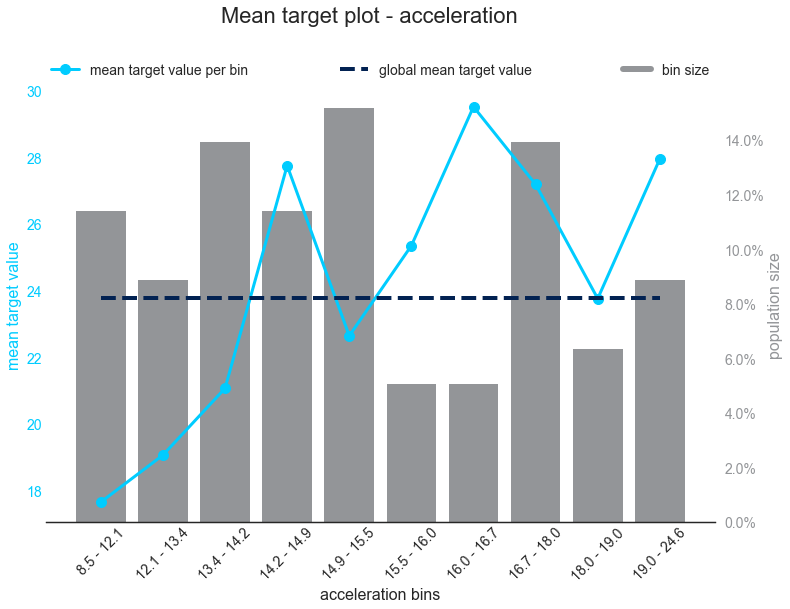

In [20]:
col_order = list(basetable["acceleration_bin"].unique().sort_values())
plot_incidence(pig_tables, variable="acceleration", model_type="regression", column_order=col_order)

## Feature selection

Once the predictors are properly prepared, we can start building a predictive model, which boils down to selecting the right predictors from the dataset to train a model on.

As a dataset typically contains many predictors, **we first perform a univariate preselection** to rule out any predictor with little to no predictive power. 

Later, using the list of preselected features, we build a multiple regression model using **forward feature selection** to choose the right set of predictors.

In previous steps, these were the predictors, as preprocessed so far:

In [21]:
preprocessed_predictors = [
    col for col in basetable.columns
    if col.endswith("_bin") or col.endswith("_processed")
]
sorted(preprocessed_predictors)

['acceleration_bin',
 'cylinders_processed',
 'displacement_bin',
 'horsepower_bin',
 'model_year_bin',
 'name_processed',
 'origin_processed',
 'weight_bin']

But for feature selection, we use the target encoded version of each of these.

In [22]:
preprocessed_predictors = [col for col in basetable.columns.tolist() if "_enc" in col]

A univariate selection on the preprocessed predictors can be conducted. The thresholds for retaining a feature can be changed by the user, for instance both at 10 for now.


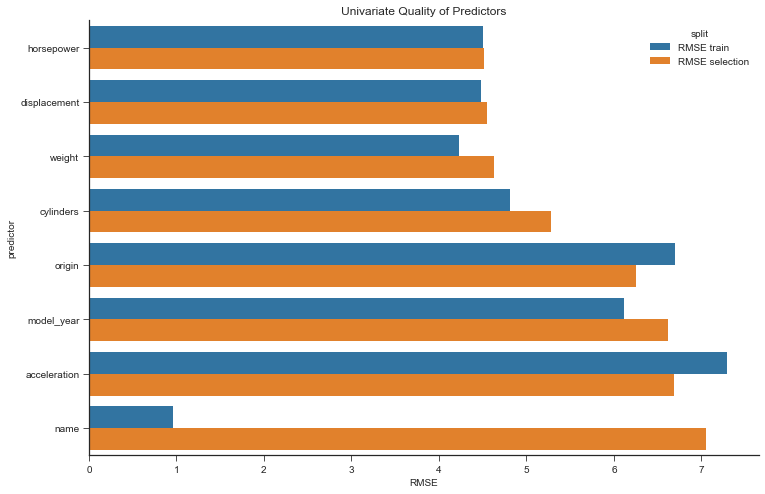

In [23]:
df_rmse = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"]=="train"],
    target_enc_selection_data=basetable[basetable["split"]=="selection"],
    predictors=preprocessed_predictors,
    target_column=target_col,
    model_type="regression",
    preselect_rmse_threshold = 10, # max. RMSE for selection
    preselect_overtrain_threshold = 10) # difference between RMSE on train and selection set

plot_univariate_predictor_quality(df_rmse)

# As the square root of a variance, RMSE can be interpreted as the standard deviation of 
# the unexplained variance, and has the useful property of being in the same units as the response variable. 
# Lower values of RMSE indicate better fit.

Next, we compute correlations between the preprocessed predictors and plot it using a correlation matrix.

In [24]:
# compute correlations between preprocessed predictors
df_corr = (univariate_selection
           .compute_correlations(basetable[basetable["split"]=="train"],
                                 preprocessed_predictors))
print(df_corr)

                origin      name  cylinders  horsepower  model_year    weight  \
origin        1.000000  0.571069   0.586881    0.503373    0.220294  0.635906   
name          0.571069  1.000000   0.806237    0.833102    0.647684  0.856403   
cylinders     0.586881  0.806237   1.000000    0.811333    0.436942  0.873356   
horsepower    0.503373  0.833102   0.811333    1.000000    0.476911  0.865079   
model_year    0.220294  0.647684   0.436942    0.476911    1.000000  0.393047   
weight        0.635906  0.856403   0.873356    0.865079    0.393047  1.000000   
acceleration  0.253132  0.441351   0.520317    0.619921    0.331274  0.410300   
displacement  0.704440  0.837183   0.919231    0.851480    0.424150  0.929419   

              acceleration  displacement  
origin            0.253132      0.704440  
name              0.441351      0.837183  
cylinders         0.520317      0.919231  
horsepower        0.619921      0.851480  
model_year        0.331274      0.424150  
weight      

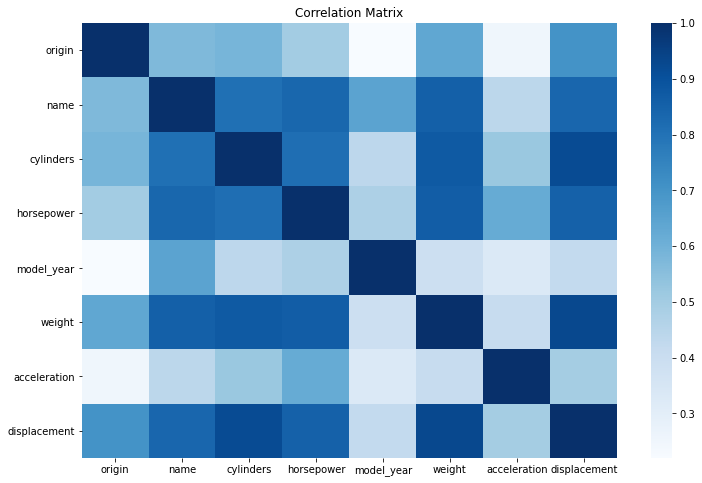

In [25]:
# plot correlation matrix
plot_correlation_matrix(df_corr)

To get a list of the selected predictors after the univariate selection, run the following call:


In [26]:
preselected_predictors = univariate_selection.get_preselected_predictors(df_rmse)
preselected_predictors

['horsepower_enc',
 'displacement_enc',
 'weight_enc',
 'cylinders_enc',
 'origin_enc',
 'model_year_enc',
 'acceleration_enc',
 'name_enc']

After an initial preselection on the predictors, we can start building the model itself using forward feature selection to choose the right set of predictors. Since we use target encoding on all our predictors, we will only consider models with positive coefficients (no sign flip should occur) as this makes the model more interpretable.

## Modeling

In [27]:
forward_selection = ForwardFeatureSelection(model_type="regression",
                                            # model_name="linear-regression",
                                            max_predictors=30,
                                            pos_only=True)

# fit the forward feature selection on the train data
# has optional parameters to force and/or exclude certain predictors (see docs)
forward_selection.fit(basetable[basetable["split"]=="train"],
                      target_column_name=target_col,
                      predictors=preselected_predictors)

# compute model performance
performances = (forward_selection
                .compute_model_performances(basetable, target_column_name=target_col))
performances

Sequentially adding best predictor...:   0%|          | 0/8 [00:00<?, ?it/s]

,predictors,last_added_predictor,train_performance,selection_performance,validation_performance,model_type
0,[name_enc],name_enc,0.965551,7.050967,6.327197,regression
1,"[name_enc, model_year_enc]",model_year_enc,0.950131,6.932540,6.223183,regression
2,"[model_year_enc, name_enc, weight_enc]",weight_enc,0.939471,6.685434,5.954216,regression
3,"[weight_enc, model_year_enc, name_enc, horsepo...",horsepower_enc,0.938280,6.656585,5.929000,regression
4,"[weight_enc, horsepower_enc, name_enc, model_y...",cylinders_enc,0.937998,6.652905,5.923981,regression
5,"[cylinders_enc, horsepower_enc, weight_enc, na...",displacement_enc,0.937729,6.654564,5.926207,regression
6,"[cylinders_enc, displacement_enc, horsepower_e...",origin_enc,0.937513,6.647764,5.917903,regression
7,"[cylinders_enc, displacement_enc, horsepower_e...",acceleration_enc,0.937498,6.646871,5.917192,regression


As can be seen, we have completed 7 steps till no further improvement can be observed

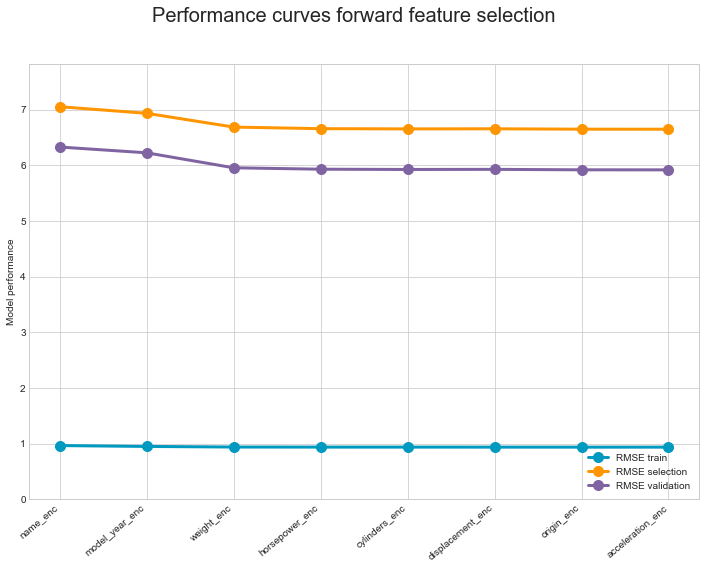

In [28]:
# plot performance curves
plot_performance_curves(performances)

Based on the performance curves (RMSE per model with a particular number of predictors in case of linear regression), a final model can then be chosen and the variables importance can be plotted:


In [29]:
# pick the optimal step based on visual inspection in the plot above (try to find a knee point)
model = forward_selection.get_model_from_step(2)

final_predictors = model.predictors
final_predictors

['model_year_enc', 'name_enc', 'weight_enc']

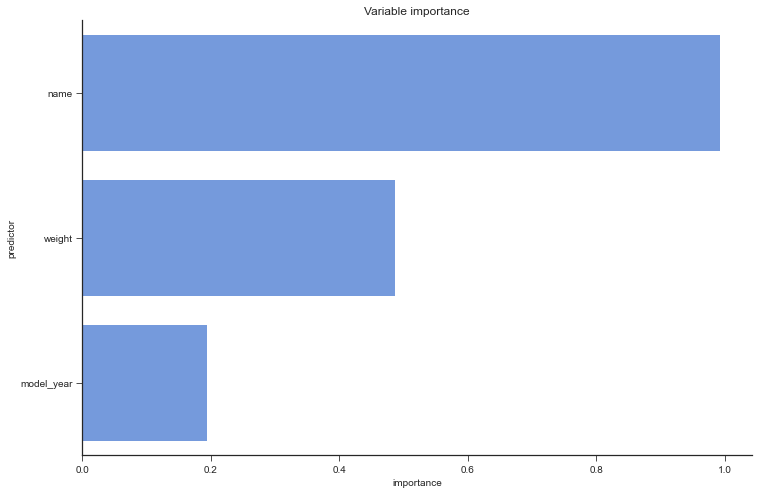

In [30]:
variable_importance = model.compute_variable_importance(
    basetable[basetable["split"]=="selection"])
plot_variable_importance(variable_importance)

**Note**: variable importance is based on correlation of the predictor with the model predictions (and not the true values!).

Finally, if wanted, we can convert the model to a dictionary to store it as JSON.

In [31]:
model_dict = model.serialize()
model_dict

{'meta': 'linear-regression',
 'predictors': ['model_year_enc', 'name_enc', 'weight_enc'],
 '_eval_metrics_by_split': {'train': 0.939470933609984,
  'selection': 6.685434152886161,
  'validation': 5.954216285392323},
 'params': {'copy_X': True,
  'fit_intercept': True,
  'n_jobs': None,
  'normalize': False},
 'coef_': [0.05772933322408178, 0.9432043504937953, 0.04340259842095151],
 'intercept_': -1.0353999755487742}

In [32]:
if False:
    ## To save the model as a JSON file, run the following snippet
    model_path = os.path.join("output", "model.json")
    with open(model_path, "w") as file:
        json.dump(model_dict, file)

    ## To reload the model again from a JSON file, run the following snippet
    with open(model_path, "r") as file:
        model_dict = json.load(file)
    model = LinearRegressionModel()
    model.deserialize(model_dict)

## Evaluation

Now that we have build and selected a final model, it is time to evaluate its predictions on the test set against various evaluation metrics. The used evaluation metrics are:

1. Coefficient of Determination (R2)
2. Mean Absolute Error (MAE)
3. Mean Squared Error (MSE)
4. Root Mean Squared Error (RMSE)

Furthermore, plotting makes the evaluation of a linear regression model a lot easier. We will use a **prediction plot**, which presents predictions from the model against actual values and a **Q-Q plot** from the standardized prediction residuals.

In [33]:
# get numpy array of True target labels and predicted values
y_true = basetable[basetable["split"]=="selection"][target_col].values
y_pred = model.score_model(basetable[basetable["split"]=="selection"])

In [34]:
evaluator = RegressionEvaluator()
evaluator.fit(y_true, y_pred)

In [35]:
evaluator.scalar_metrics

R2       0.179502
MAE      5.191685
MSE     44.695030
RMSE     6.685434
dtype: float64

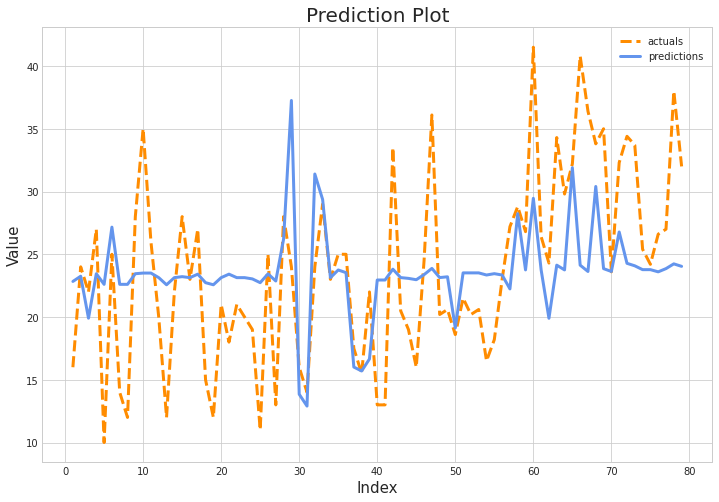

In [36]:
evaluator.plot_predictions()

In [37]:
evaluator.qq

quantiles    [-2.241402727604945, -1.9599639845400545, -1.7...
residuals    [-2.0120779188541276, -1.9153531826632304, -1....
dtype: object

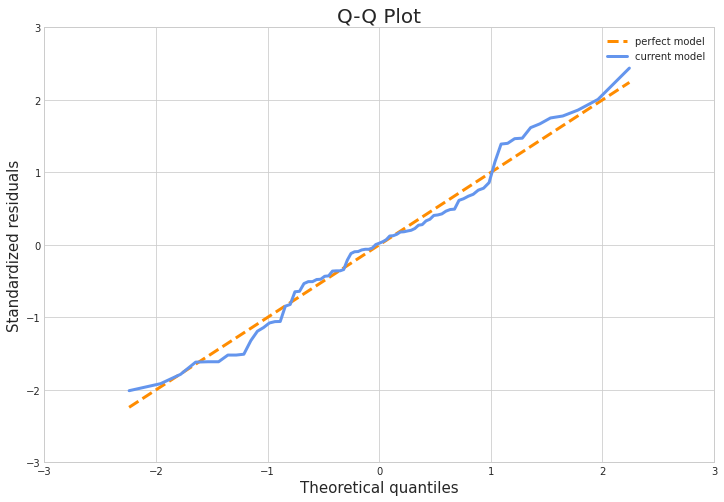

In [38]:
evaluator.plot_qq()